In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm
from datetime import datetime
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_log_error

In [2]:
rawdata= pd.read_csv("costing_data.csv")
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date_time  365 non-null    object 
 1   cost       365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


<AxesSubplot:xlabel='date_time'>

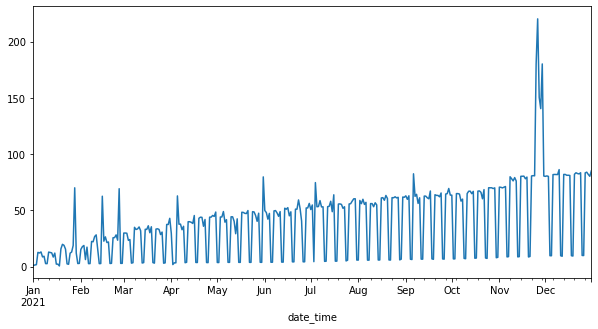

In [3]:
rawdata['date_time'] = pd.to_datetime(rawdata['date_time'])
rawdata.set_index('date_time',inplace=True)
rawdata = rawdata.sort_values(by="date_time")
fig = plt.figure(figsize =(10, 5))
rawdata['cost'].plot()

Outlier Percentage in data: 1.095890410958904%


<AxesSubplot:>

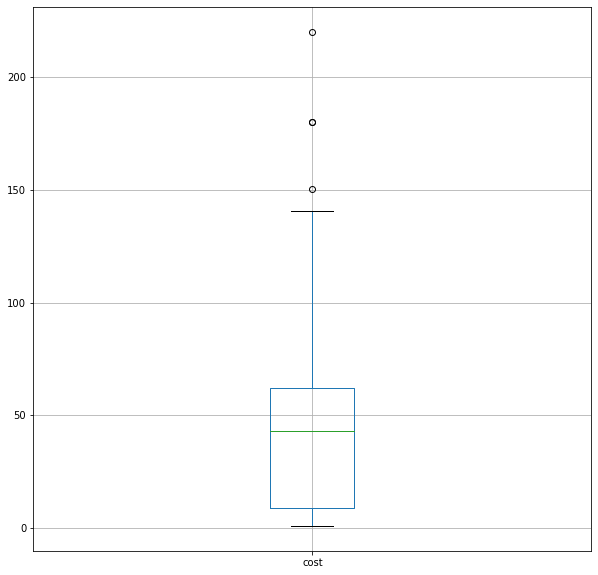

In [4]:
total_records=rawdata['cost'].count()
def getOutliers(data, col):
    Q3 = data[col].quantile(0.75)
    Q1 = data[col].quantile(0.25)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return lower_limit, upper_limit
    
lower, upper = getOutliers(rawdata, 'cost')
outliers_count = rawdata[(rawdata['cost']<lower) | (rawdata['cost']>upper)].count()['cost']
outlier_percentage = ((outliers_count / total_records) * 100)

if outlier_percentage > 20:
    NOISE = True

print(f"Outlier Percentage in data: {outlier_percentage}%")

#Render box plot
rawdata.boxplot('cost', figsize=(10,10))

In [5]:
diff_count = 0
differencing_order = {
    1: lambda x: x['cost'].diff(),
    2: lambda x: x['cost'].diff().diff(),
    3: lambda x: x['cost'].diff().diff().diff(),
    4: lambda x: x['cost'].diff().diff().diff().diff(),
    5: lambda x: x['cost'].diff().diff().diff().diff().diff()
}
while True:
    if diff_count == 0:
        adftestresult = adfuller(rawdata['cost'].dropna())
    else:
        adftestresult = adfuller(differencing_order[diff_count](rawdata).dropna())
    
    print('#' * 60)
    print('ADF Statistic: %f' % adftestresult[0])
    print('p-value: %f' % adftestresult[1])
    print(f'ADF Test Result: The time series is {"non-" if adftestresult[1] >= 0.05 else ""}stationary')
    print('#' * 60)
    
    if adftestresult[1] < 0.05 or diff_count >= len(differencing_order):
        break
    diff_count += 1
    
print("Differencing order to make data stationary: ",diff_count)

############################################################
ADF Statistic: -2.014959
p-value: 0.280053
ADF Test Result: The time series is non-stationary
############################################################
############################################################
ADF Statistic: -7.153747
p-value: 0.000000
ADF Test Result: The time series is stationary
############################################################
Differencing order to make data stationary:  1


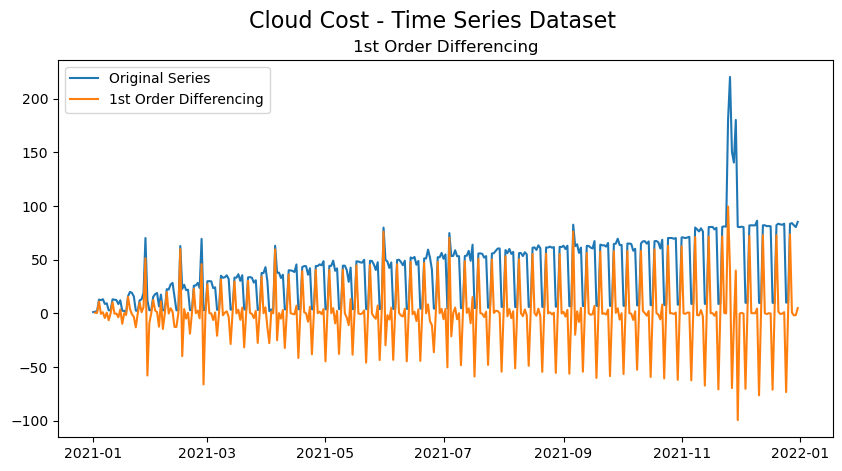

In [6]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
#  Differencing
ax.plot(rawdata.cost[:], label='Original Series')
ax.plot(rawdata.cost.diff(1), label='1st Order Differencing')
ax.set_title('1st Order Differencing')
ax.legend(loc='upper left', fontsize=10)
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Cloud Cost - Time Series Dataset', fontsize=16)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


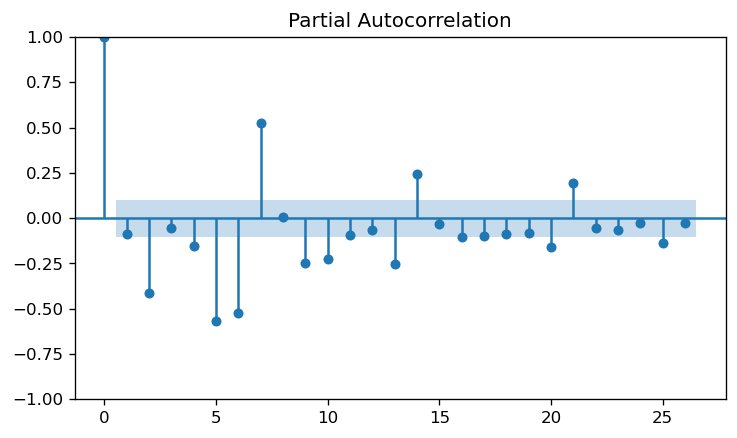

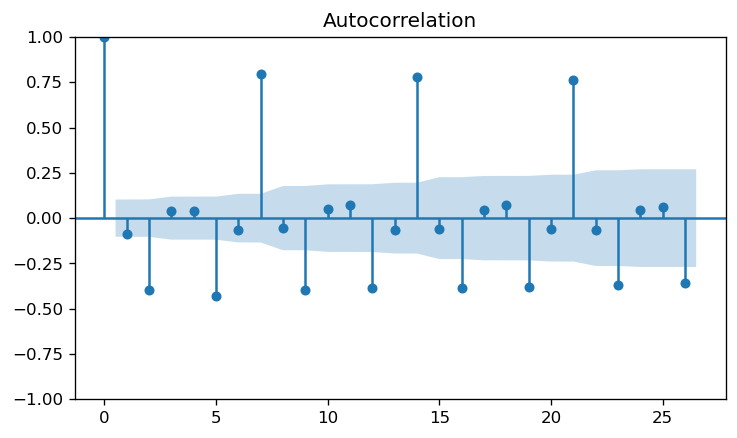

In [7]:
plt.rcParams.update({'figure.figsize':(7, 4), 'figure.dpi':120})
plot_pacf(rawdata.cost.diff().dropna());
plot_acf(rawdata.cost.diff().dropna());

breakpoint is  255
test_data count is  110


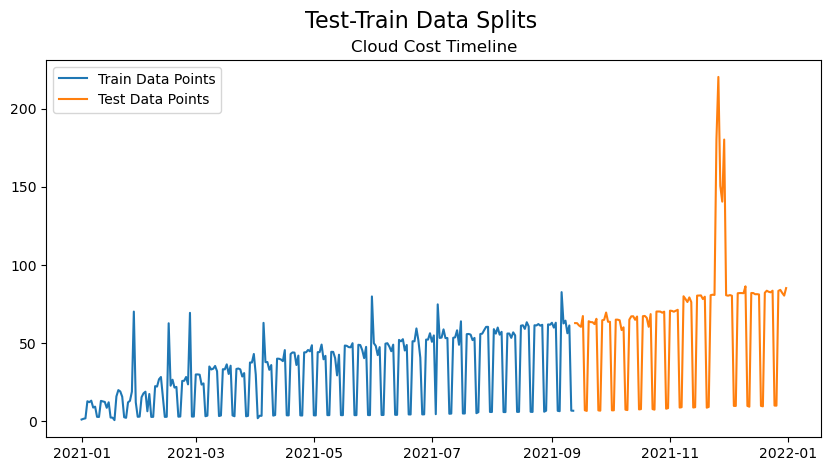

In [8]:
breakpoint = round(rawdata['cost'].count()*0.7)
print ("breakpoint is " , breakpoint)
train_data = rawdata['cost'][:breakpoint]
test_data = rawdata['cost'][breakpoint:]
print("test_data count is " , test_data.count())
fig, ax = plt.subplots(figsize=(10,5), dpi=100)

ax.plot(train_data, label='Train Data Points')
ax.plot(test_data, label='Test Data Points')
ax.set_title('Cloud Cost Timeline')
ax.legend(loc='upper left', fontsize=10)
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Test-Train Data Splits', fontsize=16)
plt.show()

In [9]:
from statsmodels.tsa.arima.model import ARIMA
manual_arima_model = ARIMA(train_data, order=(2,2,1))
manual_arima_model_fit = manual_arima_model.fit()
print(manual_arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   cost   No. Observations:                  255
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1147.684
Date:                Wed, 11 May 2022   AIC                           2303.367
Time:                        21:18:41   BIC                           2317.501
Sample:                    01-01-2021   HQIC                          2309.053
                         - 09-12-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2063      0.091     -2.270      0.023      -0.384      -0.028
ar.L2         -0.3596      0.074     -4.874      0.000      -0.504      -0.215
ma.L1         -1.0000     44.400     -0.023      0.9

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<Figure size 1500x500 with 0 Axes>

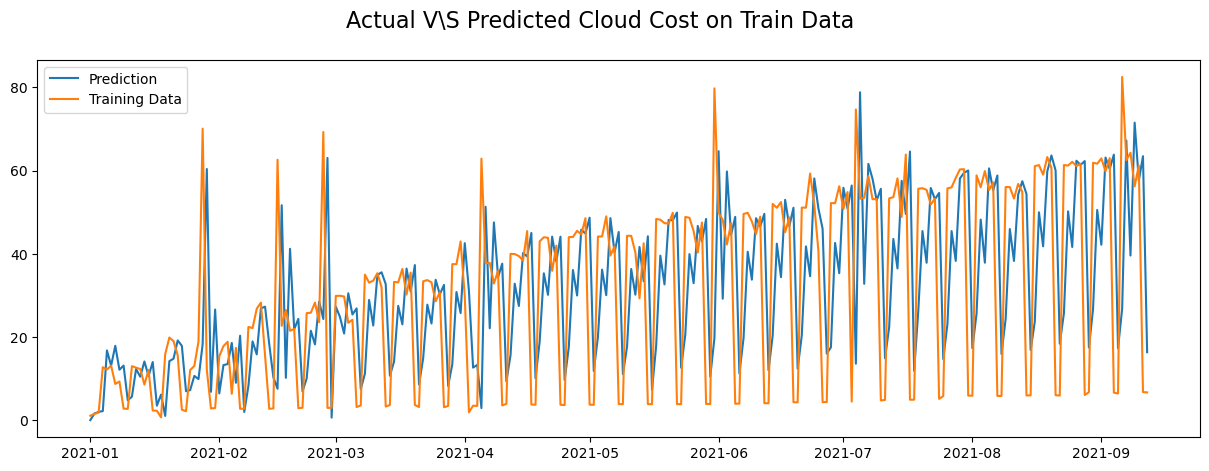

In [10]:
prediction_manual=manual_arima_model_fit.predict(dynamic=False,typ='levels')
plt.figure(figsize=(15,5), dpi=100)
fig, ax = plt.subplots(figsize=(15,5), dpi=100)
ax.plot(prediction_manual, label='Prediction')
ax.plot(train_data, label='Training Data')
ax.legend(loc='upper left', fontsize=10)
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Actual V\S Predicted Cloud Cost on Train Data', fontsize=16)
plt.show()

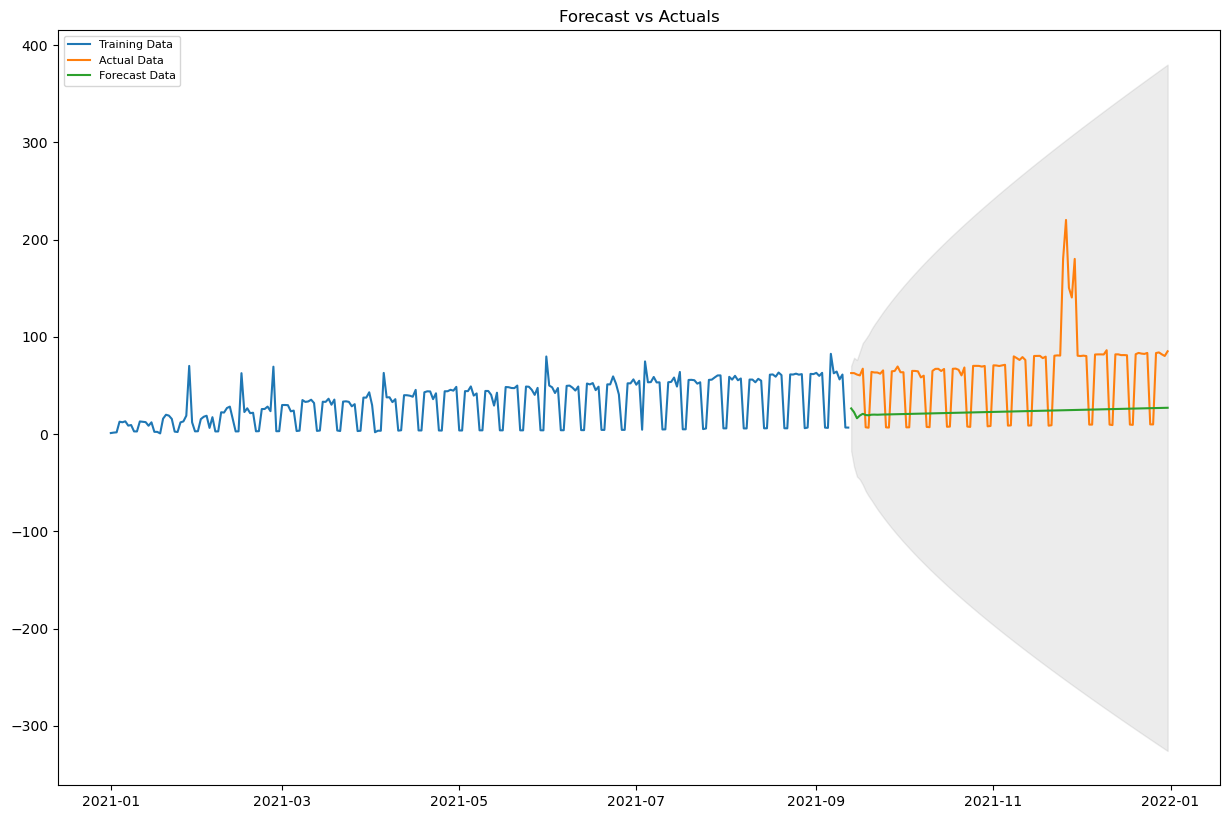

In [11]:
# Forecast with 95% confidence interval 
#testcounter=
forecast = manual_arima_model_fit.get_forecast(int(test_data.count()))
manual_arima_fc = forecast.predicted_mean
manual_arima_conf = forecast.conf_int(alpha=0.05)
manual_arima_fc_series = pd.Series(manual_arima_fc, index=test_data.index)
manual_arima_lower_series = pd.Series(manual_arima_conf["lower cost"], 
                                      index=manual_arima_conf.index)
manual_arima_upper_series = pd.Series(manual_arima_conf["upper cost"], 
                                      index=manual_arima_conf.index)
plt.figure(figsize=(15,10), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Data')
plt.plot(manual_arima_fc_series, label='Forecast Data')
plt.fill_between(manual_arima_lower_series.index, manual_arima_lower_series, 
                 manual_arima_upper_series, color='gray', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [12]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)*100)  
    mae = np.mean(np.abs(forecast - actual))       
    rmse = np.mean((forecast - actual)**2)**.5  
    rmsle = np.sqrt(mean_squared_log_error(actual, forecast))
    return({'MAPE : ':mape, 'MAE : ': mae, 
             'RMSE : ':rmse, 'RMSLE : ':rmsle
           })


forecast_accuracy(manual_arima_fc, test_data)

{'MAPE : ': 97.17226935069966,
 'MAE : ': 45.54175918870744,
 'RMSE : ': 53.70935114343316,
 'RMSLE : ': 1.1292108216737289}

In [13]:
# Fit auto_arima on train set
auto_arima_model = pm.auto_arima(train_data, start_p = 1, start_q = 1, 
                          max_p = 15, max_q = 15,  
                          seasonal = False, 
                          d = None, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)  
  
# To print the summary 
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2342.260, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2338.223, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2340.260, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2304.980, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2299.498, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2292.280, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2192.988, Time=0.11 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=1959.033, Time=0.30 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=1960.293, Time=0.42 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=1960.393, Time=0.60 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2059.771, Time=0.40 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=1948.785, Time=0.66 sec
 ARIMA(8,1,1)(0,0,0)[0] intercept   : AIC=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  255
Model:               SARIMAX(7, 1, 1)   Log Likelihood                -964.392
Date:                Wed, 11 May 2022   AIC                           1948.785
Time:                        21:18:48   BIC                           1984.158
Sample:                             0   HQIC                          1963.015
                                - 255                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1822      0.083      2.184      0.029       0.019       0.346
ar.L1         -0.0432      0.095     -0.454      0.650      -0.230       0.143
ar.L2         -0.2053      0.071     -2.894      0.004      -0.344      -0.066
ar.L3         -0.1608      0.086     -1.875      0.061      -0.329       0.007
ar.L4         -0.1263      0.093     -1.356      0.175      -0.309       0.056
ar.L5         -0.2147      0.075     -2.862      0.004      -0.362      -0.068
ar.L6         -0.0413      0.091     -0.454      0.650      -0.220       0.137
ar.L7          0.6162      0.070      8.744      0.000       0.478       0.754
ma.L1         -0.9609      0.043    -22.267      0.000      -1.045      -0.876
sigma2       107.6681      5.478     19.655      0.000      96.931     118.405
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              1746.70
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             1.13
Prob(H) (two-sided):                  0.48   Kurtosis:                        15.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

{'MAPE : ': 107.41554804636822,
 'MAE : ': 20.66679981410411,
 'RMSE : ': 32.37407206413484,
 'RMSLE : ': 0.7850714084887519}

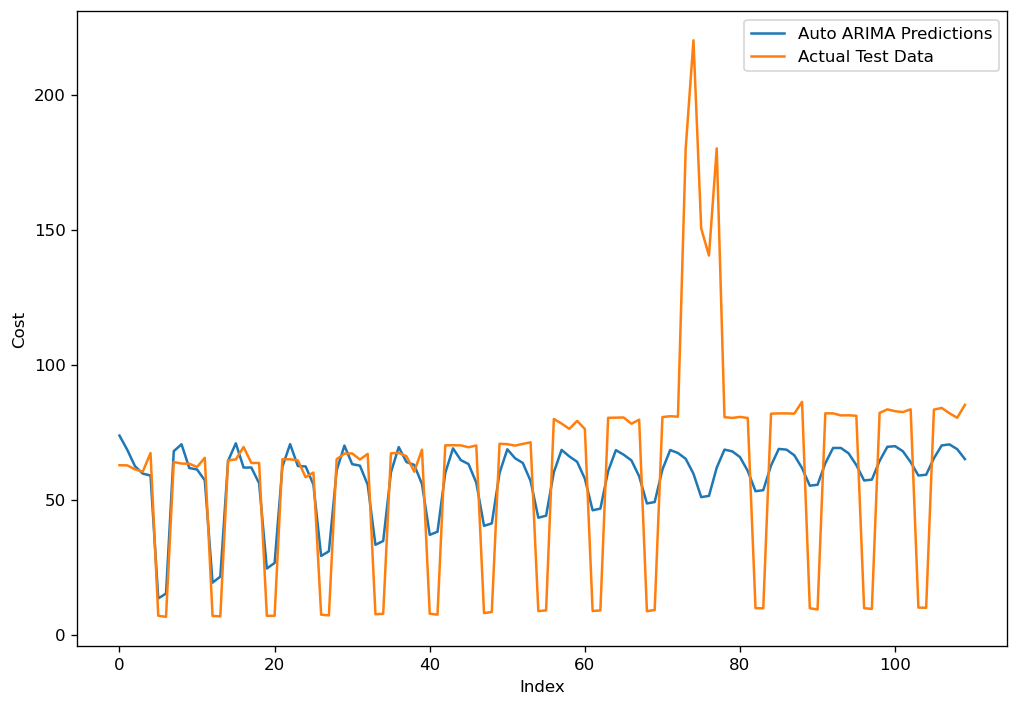

In [14]:
auto_arima_predictions = pd.Series(auto_arima_model.predict(len(test_data)))
actuals = test_data.reset_index(drop = True)
auto_arima_predictions.plot(legend = True,label = "Auto ARIMA Predictions",
                            xlabel = "Index",ylabel = "Cost", 
                            figsize=(10, 7)) 
actuals.plot(legend = True, label = "Actual Test Data");
forecast_accuracy(np.array(auto_arima_predictions), test_data)

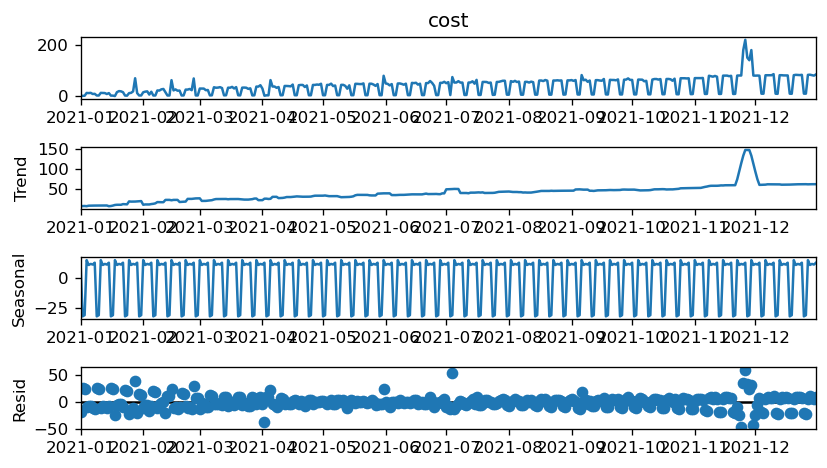

In [17]:
seasonality_check = seasonal_decompose(rawdata['cost'], 
                                       model='additive',extrapolate_trend='freq')
seasonality_check.plot(figsize=(10, 7))

plt.show()

In [18]:
# Seasonal - fit stepwise auto-ARIMA
sarima_model = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=15, max_q=15, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=1813.625, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1920.987, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1856.718, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1811.638, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1921.505, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=1922.944, Time=0.07 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=1813.284, Time=0.13 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=1813.260, Time=0.18 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=1856.717, Time=0.09 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=1809.509, Time=0.95 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=1812.775, Time=1.05 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=1815.128, Time=0.28 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=1807.244, Time=0.72 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=1811.336, Time=0.13 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:                            y   No. Observations:                  255
Model:             SARIMAX(1, 1, [1, 2], 7)   Log Likelihood                -898.622
Date:                      Wed, 11 May 2022   AIC                           1807.244
Time:                              21:18:57   BIC                           1824.811
Sample:                                   0   HQIC                          1814.316
                                      - 255                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0521      0.068      0.766      0.444      -0.081       0.185
ar.S.L7        0.9521      0.052     18.252      0.000       0.850       1.054
ma.S.L7       -1.7886      0.059    -30.195      0.000      -1.905      -1.673
ma.S.L14       0.8156      0.049     16.589      0.000       0.719       0.912
sigma2        78.8807      4.026     19.593      0.000      70.990      86.771
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              7035.46
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             3.78
Prob(H) (two-sided):                  0.24   Kurtosis:                        27.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

{'MAPE : ': 19.048993741651742,
 'MAE : ': 9.106767725983865,
 'RMSE : ': 26.78840506367355,
 'RMSLE : ': 0.39365396798229807}

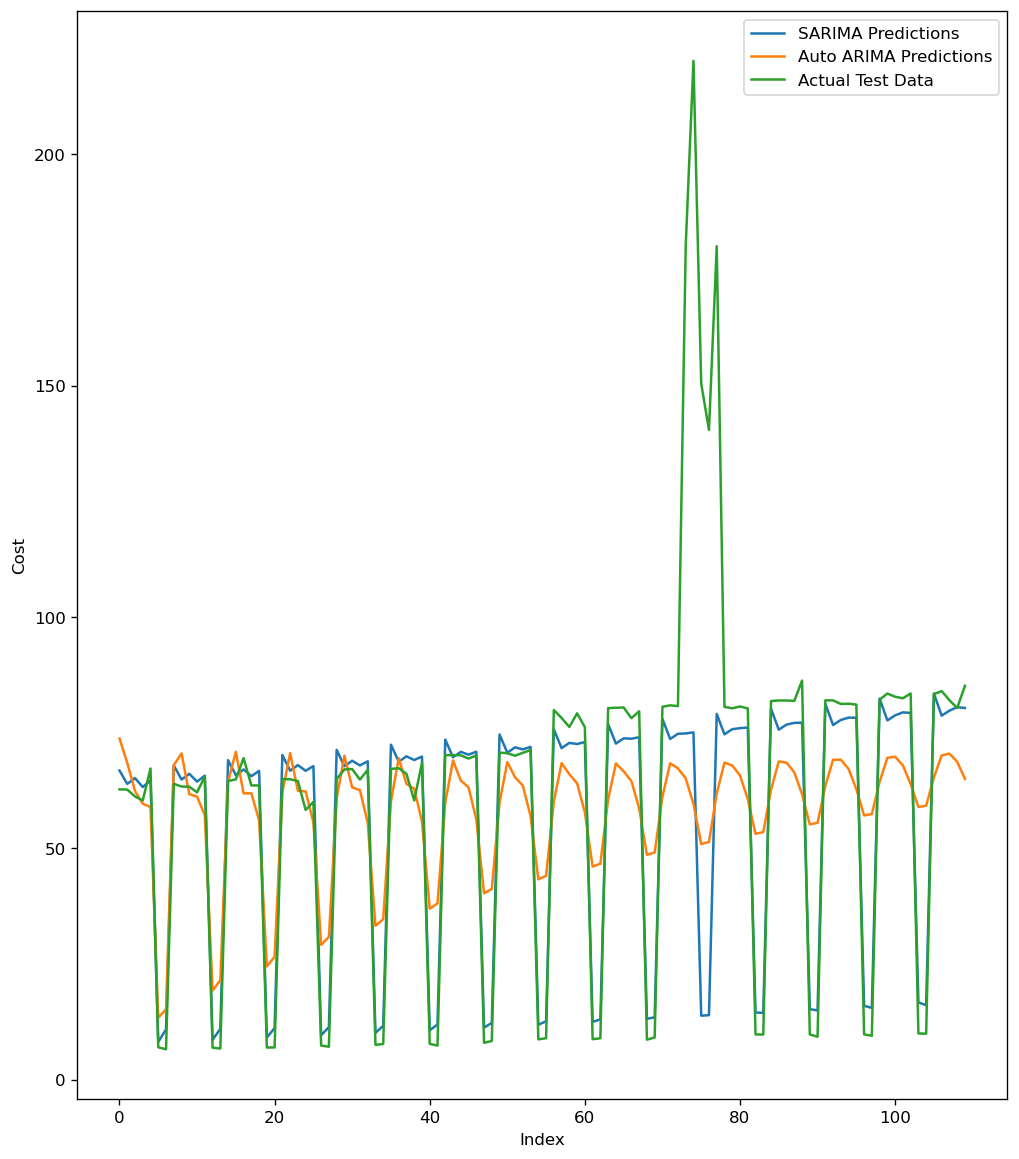

In [20]:
sarima_predictions = pd.Series(sarima_model.predict(len(test_data)))
actuals = test_data.reset_index(drop = True)
sarima_predictions.plot(legend = True,label = "SARIMA Predictions",xlabel = "Index",
                        ylabel = "Cost", figsize=(10, 12)) 

auto_arima_predictions.plot(legend = True,label = "Auto ARIMA Predictions")


actuals.plot(legend = True, label = "Actual Test Data")

forecast_accuracy(np.array(sarima_predictions), test_data)